In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy import arange, array, exp, integrate
from physoce import tseries as ts
import gsw

def neureg(x,y):
    #x,y are numpy arrays
    #subtract mean to make zero mean:
    xn = x - np.mean(x)
    yn = y - np.mean(y)
    #perform neutral regression for comparison, e.g. Garrett and Petrie 1981 and Kirincich et al 2005
    an = np.sqrt(((st.tvar(yn)))/((st.tvar(xn)))) #find slope
    bn = (np.mean(y) - an*np.mean(x)) #find intercept
    rn = np.sum(x*y)/np.sqrt((np.sum(x**2)*np.sum(y**2))) #find correlation coefficient
    slope_err = an*np.sqrt((1-rn**2)/len(x)) #compute std err in slope = a*sqrt((1-r^2)/n)
    #compute std err in intercept = vary^.5*sqrt((1-r^2)/n*(1+xmean^2/var(x))) 
    #(e.g., Miller & Kahn 1962, Statistical Analysis in the Geological Science)
    #https://stats.stackexchange.com/questions/391112/standard-error-of-coefficient-estimates-for-model-ii-regression
    inter_err = np.sqrt(st.tvar(yn))*np.sqrt(((1-rn**2)/len(x))*(1+np.mean(x)**2/st.tvar(xn))) 
    return an,bn,rn,slope_err,inter_err

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

zero = np.zeros(len(ds['time']))

In [3]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

In [4]:
good = (ds['bin_depths'] > 3)

here we perform filtering on raw u,v data from dataset before applying additional depth averages and principal axis analysis

In [5]:
#to perform filtering, first assign new data array with pl64 applied to each cross shore/along shore data
#then merge this data array with the main dataset
temp = xr.DataArray(ts.pl64(ds['u'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='u_fil')
ds = ds.merge(temp)
temp = xr.DataArray(ts.pl64(ds['v'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='v_fil')
ds = ds.merge(temp)

after obtaining filtered data, now perform depth average and rotate into principal axis

In [6]:
uda = ts.depthavg(ds['u_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds['uda'],ds['vda'])
ds['cs_da'],ds['as_da'] = rot(ds['uda'],ds['vda'],-theta+90)

t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-30 00:00:00')

Now time to work on finding baroclinic u, with depth average removed and filter applied.

Taking baroclinic crossshore velocity as the filtered velocity minus (should it be plus?) the depth average.

In [7]:
ds['cs_fil'],ds['as_fil'] = rot(ds['u_fil'],ds['v_fil'],-theta+90)
ds['cs_bar'] = ds['cs_fil'] - ds['cs_da']
ds['as_bar'] = ds['as_fil'] - ds['as_da']

begin wind analysis for qualitative comparison
---

In [8]:
def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart) #why should these be negative?
    v = -wspd*np.sin(theta_cart)
    return u,v

ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2019.nc'
ds_wind = xr.open_dataset(ncfile)

ds_wind = ds_wind.squeeze()

#get and plot alignment of wind velocity 

ds_wind['wind_east'],ds_wind['wind_north'] = wind_uv_from_spddir(ds_wind['wind_spd'], ds_wind['wind_dir'])

tau = stress(ds_wind['wind_spd'],z=4.1)
#wind stress in same direction as wind velocity, so get theta from arctan2 then use this to find components of tau
tau_east = tau*np.cos(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))
tau_north = tau*np.sin(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))

ds_wind['tau_east'] = (('time'), tau_east)
ds_wind['tau_north'] = (('time'), tau_north)

#rotate vectors to be in alongshore & crossshore direction
#theta,major,minor = princax(ds_wind['tau_east'],ds_wind['tau_north']) #rot angle is CCW rotation for vecotr or CW rotation for basis
ds_wind['tau_x'],ds_wind['tau_y'] = rot(ds_wind['tau_east'],ds_wind['tau_north'],-theta+90)

In [9]:
us, zs = ts.surface_transport(ds['cs_bar'].where(good),ds['bin_depths_avg'],ds['sea_surface'])

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:531: RuntimeWarning: All-NaN slice encountered


In [10]:
#compute theroetical ekman transport e.g. Kirincich & Barth
rho = 1026 #denisty of sea water kg/m3
f = gsw.f(ds_wind['latitude'].values) #coriolis parameter 1/s

ds_wind['uek'] = (('time'), ds_wind['tau_y']/(rho*f))

Surface and bottom buoy water velocity data analysis:
---

In [11]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument/deployment0011_CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument.ncml'
ds_surf = xr.open_dataset(ncfile)

In [12]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-01-VEL3DD000-recovered_host-vel3d_cd_dcl_velocity_data_recovered/deployment0011_CE01ISSM-MFD35-01-VEL3DD000-recovered_host-vel3d_cd_dcl_velocity_data_recovered.ncml'
ds_bott = xr.open_dataset(ncfile)

In [13]:
#define time range we are interested in
t1 = np.datetime64('2019-05-01 00:00:00')
t2 = np.datetime64('2019-09-30 00:00:00')

In [15]:
ds_surf['u'] = ds_surf['eastward_velocity']
ds_surf['v'] = ds_surf['northward_velocity']
#ds_bott_init['u'] = ds_bott_init['vel3d_c_eastward_turbulent_velocity']
#ds_bott_init['v'] = ds_bott_init['vel3d_c_northward_turbulent_velocity']

In [17]:
#ds_bott_init.where(good_time).resample(time='1h').mean() #really long run time

In [18]:
ds = ds.swap_dims({'obs':'time'})
ds_surf = ds_surf.swap_dims({'obs':'time'})
#ds_bott = ds_bott.swap_dims({'obs':'time'})

In [19]:
ds_surf['u'] = ds_surf['eastward_velocity']
ds_surf['v'] = ds_surf['northward_velocity']
ds_bott['u'] = ds_bott['vel3d_c_eastward_turbulent_velocity']
ds_bott['v'] = ds_bott['vel3d_c_northward_turbulent_velocity']

In [20]:
#extrapolate constant values for sea surface (depth<3m)
#take top bin of velocity data from adcp
ds_ali = xr.align(ds,ds_surf,ds_bott)
good = (ds_ali[0]['bin_depths_avg'] < -3)
#get location of highest good velocity bin
top_vel_bin = (ds['bin_depths_avg'] == np.max(ds['bin_depths_avg'].where(good))) 
bot_vel_bin = (ds['bin_depths_avg'] == np.min(ds['bin_depths_avg'].where(good)))
#extract highest good velocity bin into new array
for i,depth in enumerate(ds_ali[0]['bin_depths_avg'].where(top_vel_bin).values):
    if not np.isnan(depth):
        top_bin_depth = depth
        top_east_vel = ds_ali[0]['u'].T.values[i]
        top_north_vel = ds_ali[0]['v'].T.values[i]
#get surface velocity and bin depth
surf_bin_depth = -np.mean(ds_surf['pressure_mbar'].values/1000) #assuming depth=pressure in dbar
surf_east_vel = np.full(len(ds_ali[0]['time'].values), ds_ali[1]['u'].values)
surf_north_vel = np.full(len(ds_ali[0]['time'].values), ds_ali[1]['v'].values)
#perform extrapolation between two values
eastintfit = interp1d([top_bin_depth,surf_bin_depth], np.vstack([top_east_vel,surf_east_vel]), axis=0)
eastextfit = extrap1d(eastintfit) #extrapolation function from https://stackoverflow.com/questions/2745329/how-to-make-scipy-interpolate-give-an-extrapolated-result-beyond-the-input-range
northintfit = interp1d([top_bin_depth,surf_bin_depth], np.vstack([top_north_vel,surf_north_vel]), axis=0)
northextfit = extrap1d(northintfit)
#fill in array with new depths and extrapolated values:
depth_step = 0.25 #how far apart should extrapolation values be?
depth = top_bin_depth #start at top bin depth
east_vel_extrap,north_vel_extrap,dep_extrap = [],[],[]
while depth < 0-depth_step: #iterate from top of bin to surface
    depth += depth_step
    east_vel_extrap.extend(eastextfit([depth])) #for constant surface layer, change to append and insert surf_east_vel
    north_vel_extrap.extend(northextfit([depth]))
    dep_extrap.append(depth)
east_vel_extrap = np.array(east_vel_extrap)
north_vel_extrap = np.array(north_vel_extrap)
dep_extrap = np.array(dep_extrap)

In [21]:
#just try to create new dataset, aather than merge existing
#bin depth dimension for new array, based off aligned values, concatenated with surface buoy depth
new_bin_depth = []
new_bin_depth.extend(ds_ali[0]['bin_depths_avg'].where(good).values)
new_bin_depth.extend(dep_extrap)
new_bin_depth = np.array(new_bin_depth)
#time dimension for both buoys, based off aligned values
new_time = []
new_time.extend(ds_ali[0]['time'].values)
new_time = np.array(new_time)
#new variables for east and north velocities
east_vel = []
east_vel.extend(ds_ali[0]['u'].where(good).values.T)
east_vel.extend(east_vel_extrap)
east_vel = np.array(east_vel)
north_vel = []
north_vel.extend(ds_ali[0]['v'].where(good).values.T)
north_vel.extend(north_vel_extrap)
north_vel = np.array(north_vel)
#some extra necessary variables for the depth averaging
bottom_depth_avg = ds_ali[0]['bottom_depth_avg'].values
sea_surface = ds_ali[0]['sea_surface'].values

In [22]:
#combine all these data into a new dataarray 
ds_comb = xr.Dataset()
ds_comb['time'] = new_time
ds_comb['bin_depths_avg'] = new_bin_depth
ds_comb['u'] = (['bin_depths_avg','time'],east_vel)
ds_comb['v'] = (['bin_depths_avg','time'],north_vel)
ds_comb['sea_surface'] = (['time'],sea_surface)
ds_comb['bottom_depth_avg'] = ([],bottom_depth_avg)

Now it is time to redo the previous analysis with this combined data!

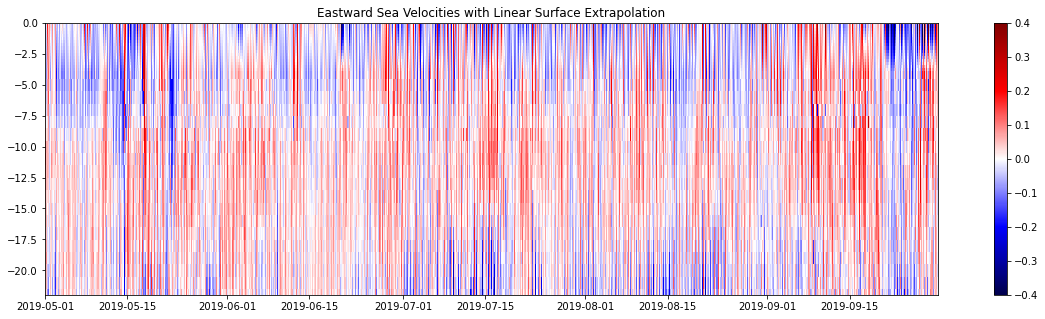

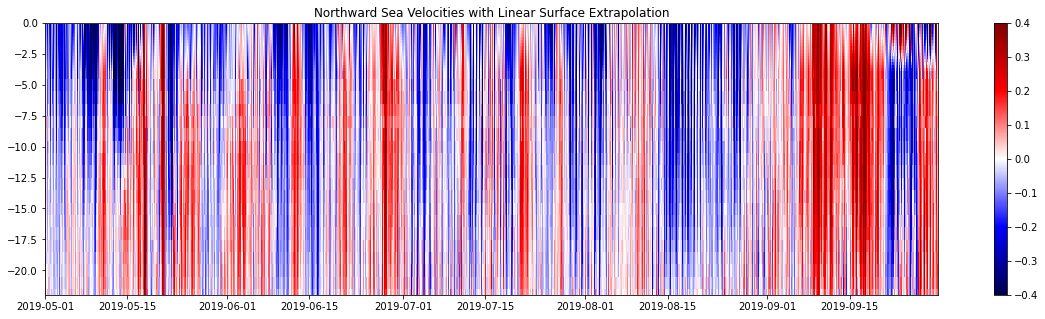

In [23]:
mask = ~np.isnan(ds_comb['bin_depths_avg'].values) #mask to avoid gap in pcolor plot at nan values
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],ds_comb['u'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Eastward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],ds_comb['v'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Northward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

In [24]:
temp = xr.DataArray(ts.pl64(ds_comb['u'].T,0.5).T,coords=(ds_comb['bin_depths_avg'],ds_comb['time']),
                    dims=('bin_depths_avg','time'),name='u_fil')
ds_comb = ds_comb.merge(temp)
temp = xr.DataArray(ts.pl64(ds_comb['v'].T,0.5).T,coords=(ds_comb['bin_depths_avg'],ds_comb['time']),
                    dims=('bin_depths_avg','time'),name='v_fil')
ds_comb = ds_comb.merge(temp)

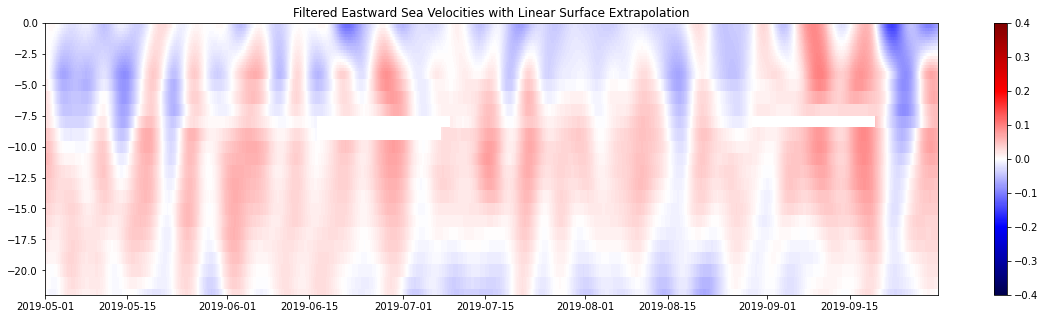

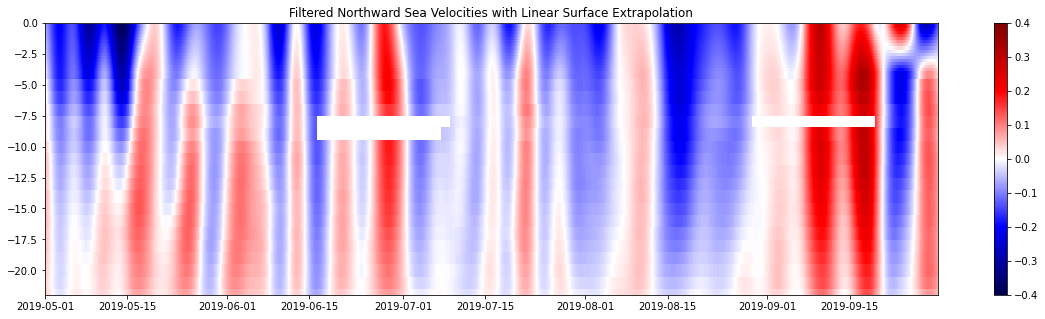

In [25]:
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],ds_comb['u_fil'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Filtered Eastward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],ds_comb['v_fil'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Filtered Northward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

In [26]:
uda = ts.depthavg(ds_comb['u_fil'].T,
                  ds_comb['bin_depths_avg'],
                  ds_comb['bottom_depth_avg'],
                  ds_comb['sea_surface'])

vda = ts.depthavg(ds_comb['v_fil'].T,
                  ds_comb['bin_depths_avg'],
                  ds_comb['bottom_depth_avg'],
                  ds_comb['sea_surface'])

ds_comb['uda'] = xr.DataArray(uda,dims='time')
ds_comb['uda'].attrs['units'] = 'm/s'
ds_comb['vda'] = xr.DataArray(vda,dims='time')
ds_comb['vda'].attrs['units'] = 'm/s'

In [27]:
theta,major,minor = princax(ds_comb['uda'],ds_comb['vda']) 
ds_comb['cs_da'],ds_comb['as_da'] = rot(ds_comb['uda'],ds_comb['vda'],-theta+90)
ds_comb['cs_fil'],ds_comb['as_fil'] = rot(ds_comb['u_fil'],ds_comb['v_fil'],-theta+90)

In [28]:
ds_comb['cs_bar'] = ds_comb['cs_fil'] - ds_comb['cs_da']
ds_comb['as_bar'] = ds_comb['as_fil'] - ds_comb['as_da']

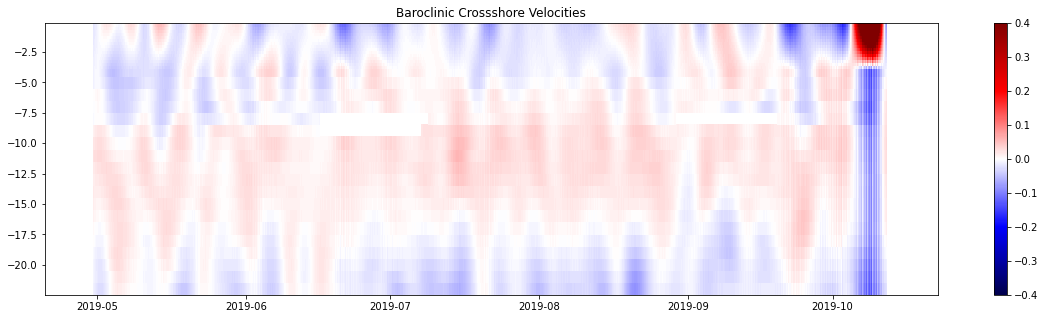

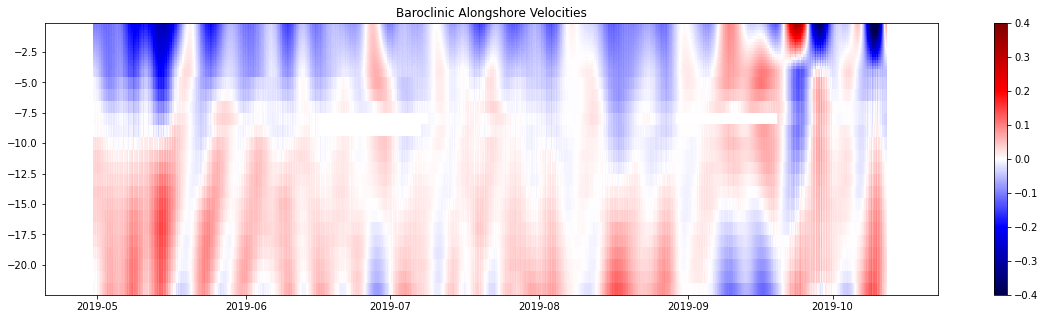

In [29]:
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],
           ds_comb['cs_bar'].values[mask],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,ds_comb['bin_depths_avg'].values[mask],
           ds_comb['as_bar'].values[mask],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Baroclinic Alongshore Velocities')
plt.colorbar()

In [30]:
us_comb, zs_comb = ts.surface_transport(ds_comb['cs_bar'].T,ds_comb['bin_depths_avg'],ds_comb['sea_surface'])

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:531: RuntimeWarning: All-NaN slice encountered


Text(0.5, 1.0, 'First zero crossing')

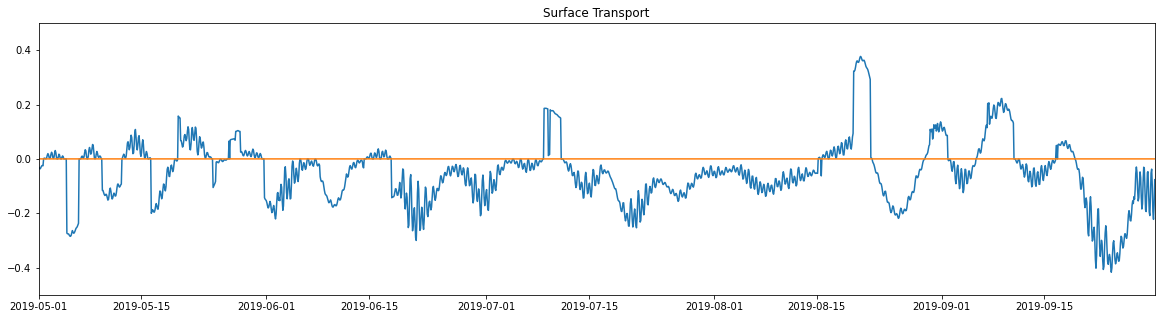

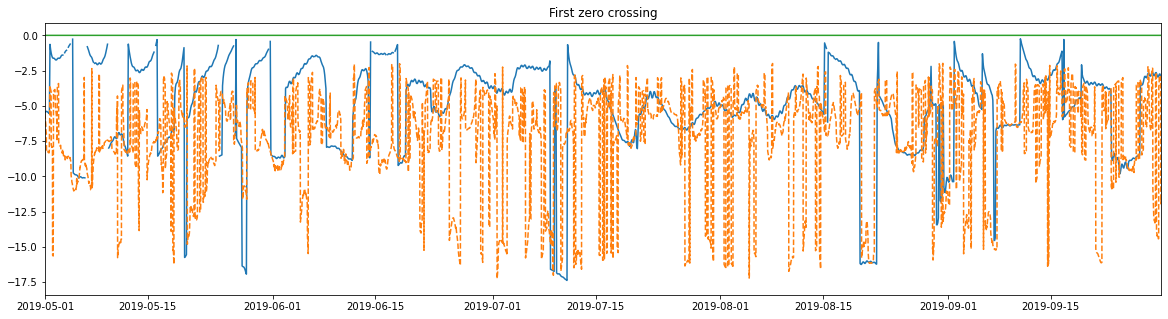

In [70]:
plt.figure(figsize=(20,5))
plt.plot(ds_comb['time'].values,us_comb)
#plt.plot(ds['time'],us,'--')
plt.plot(ds['time'],zero)
plt.xlim([t1,t2])
plt.ylim([-0.5,0.5])
plt.title('Surface Transport')

plt.figure(figsize=(20,5))
plt.plot(ds_comb['time'].values,zs_comb)
#plt.plot(ds['time'],zs,'--')
plt.plot(ds['time'],zero)
plt.xlim([t1,t2])
#plt.ylim([-0.5,0.5])
plt.title('First zero crossing')

---Transport Fraction Analysis---
---

In [39]:
ds_resa,ds_windresa = xr.align(ds,ds_wind) #bring both adcp and wind data onto common dimension of time

In [40]:
ds_windresa['ekman'] = ds_windresa['tau_y']/(1025*gsw.f(ds_windresa['latitude'].values)) 

In [41]:
good = (ds_resa['bin_depths'] > 3)
good_orig = (ds['bin_depths'] > 3)

In [42]:
#redo sea surface transport with resampled data
ustest, zstest = ts.surface_transport(ds_resa['cs_bar'].where(good),ds_resa['bin_depths_avg'],ds_resa['sea_surface']) 

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:531: RuntimeWarning: All-NaN slice encountered


Plotting new resampled data and the original, unchanged dimension data for comparison. New data is made slightly tranparent, so both can be seen. Overlapping data is brown. 

(18017.0, 18169.0)

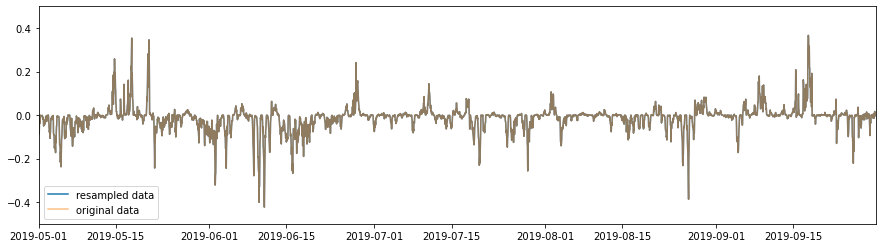

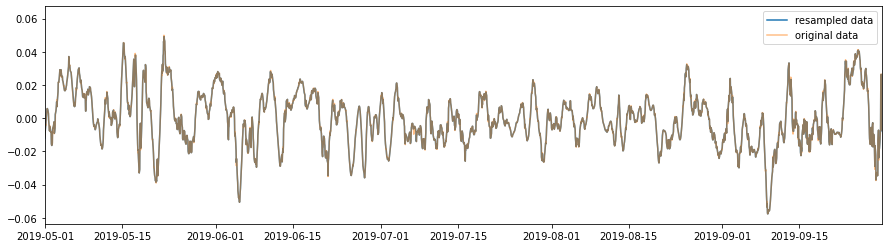

In [43]:
plt.figure(figsize=(15,4))
plt.plot(ds_windresa['time'],ds_windresa['tau_y'],label='resampled data')
plt.plot(ds_wind['time'],ds_wind['tau_y'],label='original data',alpha=0.5)
plt.legend()
plt.xlim([t1,t2])
plt.ylim([-0.5,0.5])


plt.figure(figsize=(15,4))
plt.plot(ds_resa['time'],ds_resa['cs_bar'].T[5],label='resampled data')
plt.plot(ds['time'],ds['cs_bar'].T[5],label='original data',alpha=0.5)
plt.legend()
plt.xlim([t1,t2])
#plt.ylim([-0.5,0.5])

(18017.0, 18169.0)

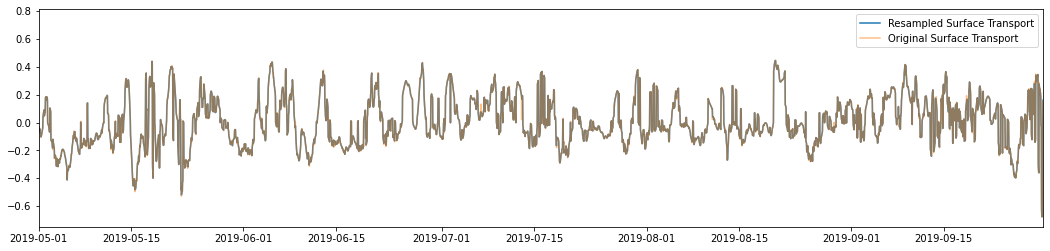

In [44]:
plt.figure(figsize=(18,4))
plt.plot(ds_resa['time'],ustest,label='Resampled Surface Transport')
plt.plot(ds['time'],us,label='Original Surface Transport',alpha=0.5)
plt.legend()
plt.xlim([t1,t2])

In [45]:
ustest = ustest.astype(float)

In [46]:
ustest[ustest == 0] = np.nan #convert zeros in array to nan

In [47]:
st.linregress(ds_windresa['ekman'].values,ustest) #lin regress not working with nan values?

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [48]:
ds_windresa['ekman'].values

array([-0.91333547, -1.05204812, -0.94319724, ..., -0.57151049,
       -1.0013065 , -1.40117239])

In [49]:
mask = ~np.isnan(ds_windresa['ekman'].values) & ~np.isnan(ustest) #mask all values with nan in them

In [50]:
st.linregress(ds_windresa['ekman'].values[mask],ustest[mask]) #now linregress works?

LinregressResult(slope=0.12449582723974498, intercept=0.020810767643416765, rvalue=0.42570412877155867, pvalue=3.495350953167967e-190, stderr=0.004022405572309611, intercept_stderr=0.002507596650110267)

In [51]:
result = st.linregress(ds_windresa['ekman'].values[mask],ustest[mask])

In [52]:
#give results names for convenience
a = result.slope
b = result.intercept
astd = result.stderr
bstd = result.intercept_stderr

Text(3, -0.4, 'a = 0.1245 $\\pm$ 0.0079\nb= 0.0208 $\\pm$ 0.0049')

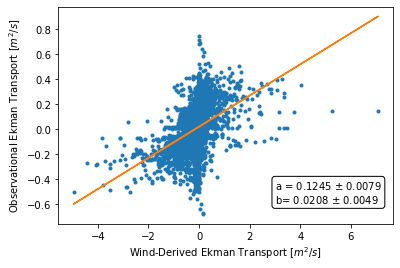

In [53]:
#plot results from linear least squares regression
plt.plot(figsize=(15,4))
plt.plot(ds_windresa['ekman'],ustest,'.')
plt.plot(ds_windresa['ekman'],ds_windresa['ekman']*a+b)
plt.xlabel('Wind-Derived Ekman Transport [$m^2/s$]')
plt.ylabel('Observational Ekman Transport [$m^2/s$]')
#plt.axis('equal')
textstr = 'a = {:.4f} $\pm$ {:.4f}\nb= {:.4f} $\pm$ {:.4f}'.format(a,1.96*astd,b,1.96*bstd)
props = dict(boxstyle='round', facecolor='w')
plt.text(3, -0.4, textstr, fontsize=10,
        verticalalignment='top', bbox=props)

Results from linear regression are shown with 95% confidence interval given as 1.96\*stderr

Literature results for 15m deployments range from a=0.18 to a=0.38, so while a=0.12 is low, it is not completely inconsistent with previous research. At 30m depths, however, a=0.75, so we are definitely on the low range of this.

In [54]:
an,bn,rn,anstd,bnstd = neureg(ds_windresa['ekman'].values[mask],ustest[mask])

Text(0, 0.5, 'Observational Ekman Transport [$m^2/s$]')

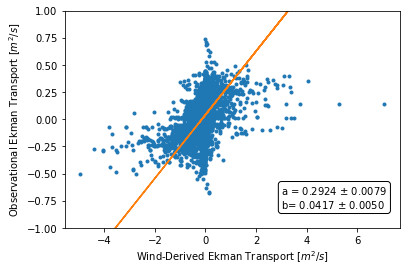

In [55]:
#plot neutral regression fits
plt.figure()
plt.plot(ds_windresa['ekman'].values[mask],ustest[mask],'.')
plt.plot(ds_windresa['ekman'].values[mask], ds_windresa['ekman'].values[mask]*an+bn) 
textstr = 'a = {:.4f} $\pm$ {:.4f}\nb= {:.4f} $\pm$ {:.4f}'.format(an,1.96*anstd,bn,1.96*bnstd)
props = dict(boxstyle='round', facecolor='w')
plt.text(3, -0.6, textstr, fontsize=10,
        verticalalignment='top', bbox=props)
plt.ylim([-1,1])
plt.xlabel('Wind-Derived Ekman Transport [$m^2/s$]')
plt.ylabel('Observational Ekman Transport [$m^2/s$]')

Nitrate flux calculations
---

To get nitrate flux, must do integral of surface layer (physoce surface_flux?) from surface to first zero crossing and bottom layer from first zero crossing to bottom.
First, though, will start with simple net nitrate flux to polish integration techniques

In [32]:
ncfile_prof = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml'
ds_no3 = xr.open_dataset(ncfile_prof+'#fillmismatch')

In [33]:
ds_no3 = ds_no3.swap_dims({'obs':'time'})

In [43]:
dt_str = '1D'  # string indicating time averaging frequency
dt = pd.to_timedelta(dt_str)   # time averaging frequency as timedelta
tmin = ds_no3['time'][0].dt.round(dt_str)    # round start date
tmax = ds_no3['time'][-1].dt.round(dt_str)   # round end date
time_grid = np.array(pd.date_range(tmin.values,tmax.values,freq=dt_str))   # array of dates

In [44]:
pmin = 0  # minimum pressure
pmax = np.max(ds_no3['pressure'])   # maximum pressure
dp = 1   # pressure averaging interval
pressure_bins = ds  # edges of pressure bins
pressure_grid = np.arange(pmin+dp/2,pmax,dp) # center of pressure bins

In [45]:
# pre-allocate gridded variable with NaNs
temperature_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)-1])
nitrate_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)-1])

85

In [56]:
for i,t in enumerate(time_grid):
    print(i)
    # find dates that fall in interval
    ti, = np.where((ds_no3['time'] >= t - dt/2) & (ds_no3['time'] < t + dt/2))
    try:
        nitrate_subset = ds_no3['nitrate_concentration'].isel(time=ti)
        nitrate_binned = nitrate_subset.groupby_bins('pressure',pressure_grid).mean()
        nitrate_grid[i,:] = nitrate_binned
    except:
        #leave as NaN for this time range if no data
        pass
#nitrate_subset

In [69]:
len(nitrate_grid)
#len(-pressure_grid)

85

In [66]:
#determine nitrate and velocity product:
ds_no3_bin = xr.Dataset()
ds_no3_bin['time'] = time_grid
ds_no3_bin['depth_from_pressure'] = -pressure_grid
#ds_no3_bin['nitrate'] = 
ds_no3_bin

<xarray.Dataset>
Dimensions:              (depth_from_pressure: 20, time: 85)
Coordinates:
  * time                 (time) datetime64[ns] 2019-05-30 ... 2019-08-22
  * depth_from_pressure  (depth_from_pressure) float64 -0.5 -1.5 ... -18.5 -19.5
Data variables:
    *empty*

In [38]:
#intergrate.simps(x=time_grid,y=nitr)